## BDEX Data Extraction

### Prereq:
- Python3.7+
- Run on `{BQNT /I:NOBOX <GO>}` and Trusted Kernel.
- Install the library first using:
    - !pip install aiohttp
    - !pip install minio

In [1]:
print("Please specify how many weeks of data you would like to extract:")
############# To manually change input ###################
number_of_weeks = 26
############# To manually change input ###################
print("You've specified "+str(number_of_weeks)+" weeks.")
print("Then please run all cells and find output in the folder bdex_output.")

Please specify how many weeks of data you would like to extract:
You've specified 26 weeks.
Then please run all cells and find output in the folder bdex_output.


### Main:

In [2]:
!pip install aiohttp

Looking in indexes: https://artifactory.inf.bloomberg.com/artifactory/api/pypi/bloomberg-pypi/simple


In [3]:
!pip install minio

Looking in indexes: https://artifactory.inf.bloomberg.com/artifactory/api/pypi/bloomberg-pypi/simple


In [4]:
import copy
from src.bdex_fe import (
    apply_and_filter,
    bdex_search,
    get_tags,
    GetData,
    PreProcessor,
)
from src.bdex_fe.products import bnef

In [5]:
query_tags = get_tags(product="bnef", number_of_weeks=number_of_weeks)
query_tags

['dskt2.AswoNewsStory.week.202232',
 'dskt2.AswoNewsStory.week.202231',
 'dskt2.AswoNewsStory.week.202230',
 'dskt2.AswoNewsStory.week.202229',
 'dskt2.AswoNewsStory.week.202228',
 'dskt2.AswoNewsStory.week.202227',
 'dskt2.AswoNewsStory.week.202226',
 'dskt2.AswoNewsStory.week.202225',
 'dskt2.AswoNewsStory.week.202224',
 'dskt2.AswoNewsStory.week.202223',
 'dskt2.AswoNewsStory.week.202222',
 'dskt2.AswoNewsStory.week.202221',
 'dskt2.AswoNewsStory.week.202220',
 'dskt2.AswoNewsStory.week.202219',
 'dskt2.AswoNewsStory.week.202218',
 'dskt2.AswoNewsStory.week.202217',
 'dskt2.AswoNewsStory.week.202216',
 'dskt2.AswoNewsStory.week.202215',
 'dskt2.AswoNewsStory.week.202214',
 'dskt2.AswoNewsStory.week.202213',
 'dskt2.AswoNewsStory.week.202212',
 'dskt2.AswoNewsStory.week.202211',
 'dskt2.AswoNewsStory.week.202210',
 'dskt2.AswoNewsStory.week.202209',
 'dskt2.AswoNewsStory.week.202208',
 'dskt2.AswoNewsStory.week.202207']

In [6]:
# from sample_data import all_recs
all_recs = await bdex_search(
    query_tags,
    proxy=None  # not needed on (?:nj|ny)lxdev\d or CORP
)

In [7]:
TAG_FILTERS = {  # example
    "and_tags": [  # contains all
#         "dskt2.AswoNewsStory.language.ENGLISH",
#         "dskt2.AswoNewsStory.jflo.indexed.true"
    ],
    "or_tags": [  # contains any
        
    ],
    "no_tags": [  # contains none
        
    ],
    "any_substr": [  # contains in any
#         "AswoNewsStory"
    ],
}
GET_DATA = {
    "doc_needed": False,
    "source_data_needed": False,
    # if any of the above are True, fill these:
    "bcos_account": None,
    "bcos_secret": None,
    "minio_access": None,
    "minio_secret": None
}

functions = []
preproc = PreProcessor(**TAG_FILTERS)
get_data_client = GetData(**GET_DATA)

product_specific_extraction_functions = [bnef.extract_suid, bnef.extract_resolution]


functions = (preproc.functions +
             product_specific_extraction_functions +
             get_data_client.functions +
             [])  # potential tokenisers

In [8]:
recs = copy.deepcopy(all_recs)
for f in functions:
    apply_and_filter(recs, f)

processing extract_tags                 :  87740 records |███████████| 100%[-00:00,  214573.05 records/s] 00:00
processing extract_suid                 :  87740 records |███████████| 100%[-00:00,  400663.51 records/s] 00:00
processing extract_resolution           :  87740 records |███████████| 100%[-00:00,  470293.25 records/s] 00:00


In [9]:
recs[0]

{'tags': ['dskt2.AswoNewsStory.BNEF-1020842.financing_id.NA',
  'dskt2.AswoNewsStory.BNEF-1020842.resolution_time.2022-08-08T07:03:14.073Z',
  'dskt2.AswoNewsStory.jflo.indexed.true',
  'dskt2.AswoNewsStory.jflo.week.202232',
  'dskt2.AswoNewsStory.BNEF-1020842.resolution.Rejected',
  'dskt2.AswoNewsStory.BNEF-1020842.reason.Irrelevant Content',
  'dskt2.AswoNewsStory.BNEF-1020842.asset_id.NA',
  'dskt2.AswoNewsStory.BNEF-1020842.region.APAC',
  'dskt2.AswoNewsStory.jflo.issue.BCE-39165',
  'dskt2.AswoNewsStory.jflo.issue.BNEF-1020842',
  'dskt2.AswoNewsStory.jflo.created.true',
  'dskt2.AswoNewsStory.region_score.false',
  'dskt2.AswoNewsStory.region.false',
  'dskt2.AswoNewsStory.wireId.1811',
  'dskt2.AswoNewsStory.language.CHINESE_SIMP',
  'dskt2.AswoNewsStory.niCodes.GDNEFWIND',
  'dskt2.AswoNewsStory.headline.中国风能产业网: 国内全容量最大的海上风电升压站项目开工',
  'dskt2.AswoNewsStory.topicClusterId.RGA7O4MB2SJN',
  'dskt2.AswoNewsStory.class.50857',
  'dskt2.AswoNewsStory.wireCode.NS6',
  'dskt2.AswoN

### Exporting as a Table via Reverse Engineering

In [10]:
import pandas as pd
from datetime import date
import re

today = date.today()

def tags_list_to_dict(cell):
    tags_dict = dict()
    issue_info_list = [] # to store info starting with 'dskt2.AswoNewsStory.BNEF-xxxxxx.'
    for i in cell:
        #jflo related tags
        if i.startswith('dskt2.AswoNewsStory.jflo.indexed.'):
            tags_dict['jflo.indexed'] = i.partition('dskt2.AswoNewsStory.jflo.indexed.')[2]
        if i.startswith('dskt2.AswoNewsStory.jflo.created.'):
            tags_dict['jflo.created'] = i.partition('dskt2.AswoNewsStory.jflo.created.')[2]  
        if i.startswith('dskt2.AswoNewsStory.jflo.week.'):
            tags_dict['jflo.week'] = i.partition('dskt2.AswoNewsStory.jflo.week.')[2] 
            
        # non-archived
        if i.startswith('dskt2.AswoNewsStory.jflo.issue.'):
            # there might be multiple issues per source, recording the existence of such
            jflo_id = i.partition('dskt2.AswoNewsStory.jflo.issue.')[2]  
            if 'jflo.issue' in tags_dict.keys():
                if str(tags_dict['jflo.issue']) != str(jflo_id):
                    tags_dict['multiple_issue'] = "Yes"
                    tags_dict['jflo.issue'] = jflo_id # regard the one with 'jflo.issue' prefix as the dominant one
            else:
                tags_dict['jflo.issue'] = jflo_id
        # archived: here we take the first BNEF id in the string as 'jflo.issue'
        if i.startswith('dskt2.AswoNewsStory.BNEF-'):
            m = re.search('dskt2.AswoNewsStory.BNEF-(.+?)\.', i)
            if m:
                jflo_id = 'BNEF-'+m.group(1)            
                # there might be multiple issues per source, recording the existence of such
                if 'jflo.issue' in tags_dict.keys():
                    if str(tags_dict['jflo.issue']) != str(jflo_id):
                        tags_dict['multiple_issue'] = "Yes"
                else:
                    tags_dict['jflo.issue'] = jflo_id  
                    
        #source related tags
        if i.startswith('dskt2.AswoNewsStory.wireId.'):
            tags_dict['wireId'] = i.partition('dskt2.AswoNewsStory.wireId.')[2]
        if i.startswith('dskt2.AswoNewsStory.wireCode.'):
            tags_dict['wireCode'] = i.partition('dskt2.AswoNewsStory.wireCode.')[2]        
        if i.startswith('dskt2.AswoNewsStory.class.'):
            tags_dict['class'] = i.partition('dskt2.AswoNewsStory.class.')[2]
        if i.startswith('dskt2.AswoNewsStory.suid.'):
            tags_dict['tags_suid'] = i.partition('dskt2.AswoNewsStory.suid.')[2]
        if i.startswith('dskt2.AswoNewsStory.headline.'):
            tags_dict['headline'] = i.partition('dskt2.AswoNewsStory.headline.')[2]        
        if i.startswith('dskt2.AswoNewsStory.topicClusterId.'):
            tags_dict['topicClusterId'] = i.partition('dskt2.AswoNewsStory.topicClusterId.')[2]     
        if i.startswith('dskt2.AswoNewsStory.niCodes.'):
            tags_dict['niCodes'] = i.partition('dskt2.AswoNewsStory.niCodes.')[2]          
        if i.startswith('dskt2.AswoNewsStory.language.'):
            tags_dict['language'] = i.partition('dskt2.AswoNewsStory.language.')[2]           
        if i.startswith('dskt2.AswoNewsStory.arrivalTime.'):
            tags_dict['arrivalTime'] = i.partition('dskt2.AswoNewsStory.arrivalTime.')[2]  
        #other info
        if i.startswith('dskt2.AswoNewsStory.region_score.'):
            tags_dict['region_score'] = i.partition('dskt2.AswoNewsStory.region_score.')[2]    
        if i.startswith('dskt2.AswoNewsStory.region.'):
            tags_dict['region'] = i.partition('dskt2.AswoNewsStory.region.')[2]          
        if i.startswith('dskt2.AswoNewsStory.spam_score.'):
            tags_dict['spam_score'] = i.partition('dskt2.AswoNewsStory.spam_score.')[2] 
        if i.startswith('dskt2.AswoNewsStory.week.'):
            tags_dict['week'] = i.partition('dskt2.AswoNewsStory.week.')[2]   
        #currently not including details related to individual jflo issues that were clones
        #individual issue info
        if i.startswith('dskt2.AswoNewsStory.BNEF-'):
            issue_info_list.append(i.partition('dskt2.AswoNewsStory.')[2])    
    #iterate to record key JFLO issue details into dictionary
    if 'jflo.issue' in tags_dict:
        prefix = tags_dict['jflo.issue'] 
        for i in issue_info_list:
            if i.startswith(prefix + '.region.'):
                tags_dict['jflo_region'] = i.partition(prefix + '.region.')[2]   
            if i.startswith(prefix + '.asset_id.'):
                tags_dict['jflo_asset_id'] = i.partition(prefix + '.asset_id.')[2]             
            if i.startswith(prefix + '.resolution_time.'):
                tags_dict['jflo_resolution_time'] = i.partition(prefix + '.resolution_time.')[2]             
            if i.startswith(prefix + '.reason.'):
                tags_dict['jflo_reason'] = i.partition(prefix + '.reason.')[2]               
            if i.startswith(prefix + '.financing_id.'):
                tags_dict['jflo_financing_id'] = i.partition(prefix + '.financing_id.')[2]    
            if i.startswith(prefix + '.resolution.'):
                tags_dict['jflo_resolution'] = i.partition(prefix + '.resolution.')[2]  
    return tags_dict

In [11]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

comb = pd.DataFrame()
for r in recs:
    temp = pd.DataFrame(list(r.items())).set_index(0).transpose()
    comb = comb.append(temp)
#unstack tags content into multiple columns    
res = comb['tags'].apply(tags_list_to_dict).apply(pd.Series)
res = pd.concat([comb.drop(['tags'], axis=1), res], axis=1)
res.head()

,doc_sha,document,sourcedata,mime_type,asof,suid,resolution,jflo.issue,jflo.indexed,jflo.week,multiple_issue,jflo.created,region_score,region,wireId,language,niCodes,headline,topicClusterId,class,wireCode,arrivalTime,tags_suid,week,spam_score,jflo_financing_id,jflo_resolution_time,jflo_resolution,jflo_reason,jflo_asset_id,jflo_region
1,ea515da1f2d1b008130facaa27909de358c4f2cf844b44...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-08T05:38:32.321000+00:00,RGA7O4MB2SJN,Rejected,BNEF-1020842,true,202232,Yes,true,false,false,1811,CHINESE_SIMP,GDNEFWIND,中国风能产业网: 国内全容量最大的海上风电升压站项目开工,RGA7O4MB2SJN,50857,NS6,2022-08-08T05:38:28.639Z,RGA7O4MB2SJN,202232,false,NA,2022-08-08T07:03:14.073Z,Rejected,Irrelevant Content,NA,APAC
1,de5266a681cf78089308498df0152653f0ae3a056ab00a...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-08T06:57:14.684000+00:00,RGABBEMB2SJP,Rejected,BCE-39207,true,202232,Yes,true,false,false,1810,GERMAN,GDNEFSOLAR,Merkur: Cyclo baut großen Solarpark,RGABBEMB2SJP,14694,NS5,2022-08-08T06:57:14.271Z,RGABBEMB2SJP,202232,false,NaN,NaN,NaN,NaN,NaN,NaN
1,2af77edb63e6a8c97903d437dc7f8b298d41f061ef9b27...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-08T07:46:58.339000+00:00,RGADM9C6YGW1,Rejected,BCE-39236,true,202232,Yes,true,100,EMEA,2291,ENGLISH,GDNEFSOLAR,Prospex Energy Completes Solar Panel Installat...,TlK/9IMGYoK53ratN1pK79w==,2,MTN,2022-08-08T07:46:57.501Z,RGADM9C6YGW1,202232,69,NaN,NaN,NaN,NaN,NaN,NaN
1,d2a2c6450c4750582cefaac345df4b74850d3f9ee78ca2...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-08T04:01:59.018000+00:00,RGA37AMB2SJP,Rejected,BNEF-1020802,true,202232,Yes,true,100,AMER,1819,ENGLISH,GDNEFWIND,Townhall Finance: Va. Ratepayers to Front Cost...,WSbYaZgsh9uIrQY9TSehfJA==,16531,BLG,2022-08-08T04:01:58.064Z,RGA37AMB2SJP,202232,88,NA,2022-08-08T05:45:33.942Z,Rejected,Record already up-to-date,NA,AMER
1,b59de8535b2ca2280fcbc81c6cd2a7c12ea0ccf0d74dc8...,https://bcos.prod.blpprofessional.com/v1/dt.ex...,[],text/html,2022-08-08T06:41:36.239000+00:00,RGAALBMB2SJM,Rejected,BNEF-1020908,true,202232,Yes,true,100,EMEA,1813,ENGLISH,GDNEFSOLAR,IPP Media: UAE’s Masdar plans for 2000MW renew...,RGAALBMB2SJM,9982,NS8,2022-08-08T06:41:35.236Z,RGAALBMB2SJM,202232,12,NA,2022-08-08T09:05:55.381Z,Rejected,Not enough information for update,NA,EMEA


In [13]:
# to avoid Excel's limit of 65,530 URLS per worksheet
writer = pd.ExcelWriter('bdex_output/res-'+str(today)+'.xlsx', engine='xlsxwriter',options={'strings_to_urls': False})
res.to_excel(writer)
writer.close()

# Major Rejected Sources 

In [14]:
#filter jflo_Resolution = "Rejected"
newRes=res[res['jflo_resolution']=='Rejected']
#find duplicate of combinations (class+wireId) from rejected 
newRes=newRes[newRes.duplicated(['class','wireId'], keep=False)]

#counts duplicate sources
duplicateCount= newRes.pivot_table(index = ['wireId', 'class'], aggfunc ='size')

duplicateCount=duplicateCount.reset_index()
duplicateCount.columns = ['wireId', 'class', 'count']

import numpy as np
duplicateCount['rejection%']=(duplicateCount['count']/res.shape[0]*100)

In [15]:
#widget for threshold
import ipywidgets as widgets
from IPython.display import display

w = widgets.FloatText(
    value = 0.5,
    description ='Major Rejection % Threshold',
    diabled = False,
    style={'description_width': 'initial'}
)
display(w)

FloatText(value=0.5, description='Major Rejection % Threshold', style=DescriptionStyle(description_width='init…

In [16]:
#finds sources that has been rejected more than certain threshold
duplicateCount.drop(duplicateCount[duplicateCount['rejection%'] < w.value].index, inplace = True)
majorRej=duplicateCount
majorRej=majorRej.reset_index(drop=True)

In [17]:
duplicateCount

,wireId,class,count,rejection%
298,1806,16514,595,1.461701
356,1806,18680,265,0.651010
358,1806,18689,239,0.587137
584,1808,11412,248,0.609247
985,1810,14927,244,0.599420
1244,1811,12252,851,2.090601
1254,1811,50712,707,1.736845
1266,1811,50857,219,0.538004
1284,1811,50945,856,2.102884
1314,1811,51060,215,0.528178


In [18]:
#rejection reason for duplicate sources(wire+class)

#DOES NOT ACCOUNT FOR THRESHOLD     
countReason= newRes.pivot_table(index = ['wireId', 'class', 'jflo_reason'], aggfunc ='size')
countReason=countReason.reset_index()

#grabbing only the major rejects reasons --threshold

majorRejRes=countReason.merge(majorRej, on=['wireId','class'],how='inner')
majorRejRes=majorRejRes.drop(['count','rejection%'], axis=1)
majorRejRes.columns=['wireId', 'class', 'jflo_reason', 'count']


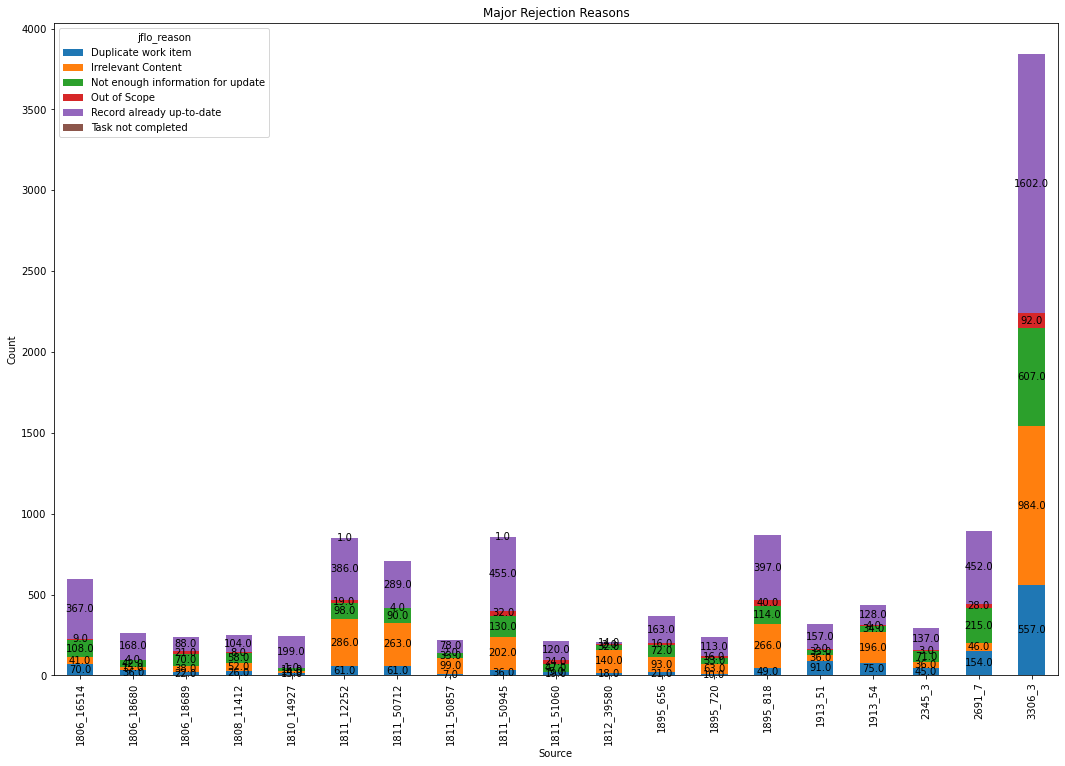

In [19]:
import matplotlib.pyplot as plt

#make stacked graph 
# x-axis = source
# y-axis = count (group by jflo reason)
# stacked = jflo_reason

majorRejRes['Source'] = majorRejRes['wireId'] + '_' + majorRejRes['class']

majorRejRes = majorRejRes.pivot_table(index=['Source'], columns = ['jflo_reason'], values='count')
ax = majorRejRes.plot(kind='bar', stacked = True, figsize = (18,12), rot = 90, xlabel = 'Source', ylabel='Count', title = 'Major Rejection Reasons')
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels = labels, label_type='center')

In [20]:
majorRejRes.loc['Total'] = majorRejRes.sum()
majorRejRes

jflo_reason,Duplicate work item,Irrelevant Content,Not enough information for update,Out of Scope,Record already up-to-date,Task not completed
Source,,,,,,
1806_16514,70.0,41.0,108.0,9.0,367.0,NaN
1806_18680,36.0,15.0,42.0,4.0,168.0,NaN
1806_18689,22.0,38.0,70.0,21.0,88.0,NaN
1808_11412,26.0,52.0,58.0,8.0,104.0,NaN
1810_14927,15.0,14.0,15.0,1.0,199.0,NaN
1811_12252,61.0,286.0,98.0,19.0,386.0,1.0
1811_50712,61.0,263.0,90.0,4.0,289.0,NaN
1811_50857,7.0,99.0,33.0,2.0,78.0,NaN
1811_50945,36.0,202.0,130.0,32.0,455.0,1.0


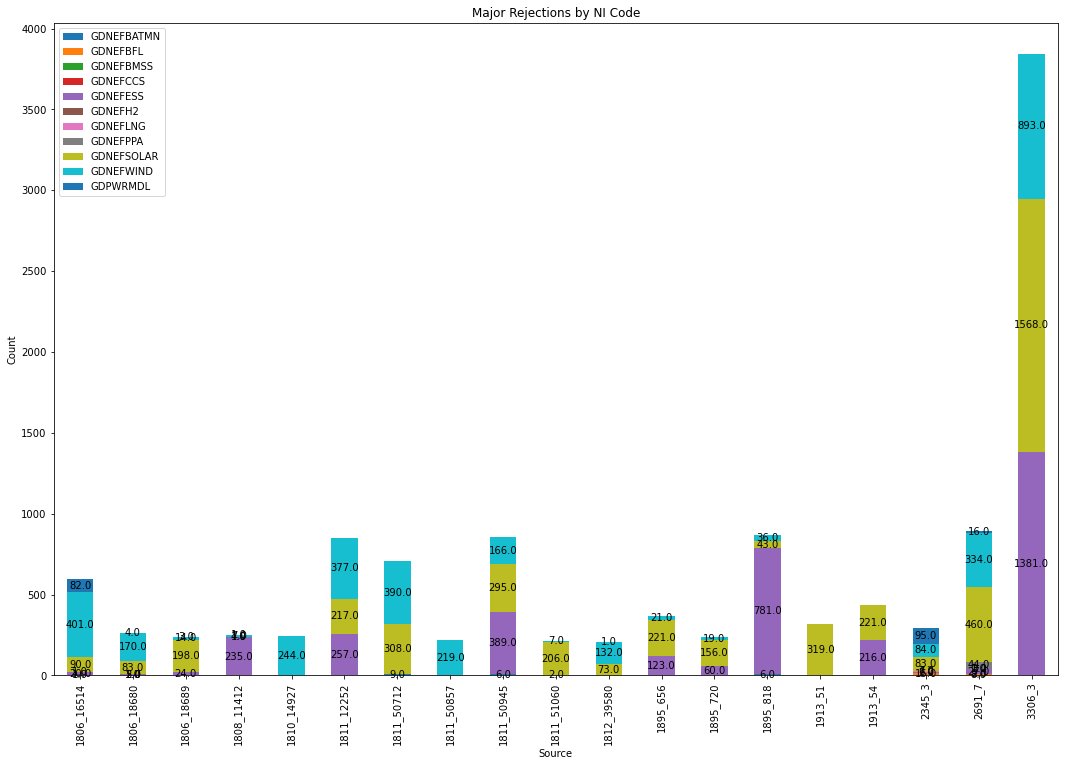

In [21]:
majorRej['Source'] = majorRej['wireId']+'_'+ majorRej['class']
newRes['Source'] = newRes['wireId']+'_'+ newRes['class']
niRefine = newRes.pivot_table(index =['Source'], columns = ['niCodes'], aggfunc='size')

niRefine = pd.merge(niRefine.reset_index(), majorRej, how = 'inner').set_index('Source')
ni_Refine = niRefine.drop(['wireId','class','rejection%','count'], axis=1)

ax = ni_Refine.plot(kind='bar', stacked = True, figsize = (18,12), rot = 90, xlabel = 'Source', ylabel='Count', title='Major Rejections by NI Code')
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels = labels, label_type='center')

In [22]:
#get the total of major rejects by ni code
ni_Refine.loc["Total"] = niRefine.sum()
ni_Refine

,GDNEFBATMN,GDNEFBFL,GDNEFBMSS,GDNEFCCS,GDNEFESS,GDNEFH2,GDNEFLNG,GDNEFPPA,GDNEFSOLAR,GDNEFWIND,GDPWRMDL
Source,,,,,,,,,,,
1806_16514,NaN,NaN,1.0,NaN,20.0,1.0,NaN,NaN,90.0,401.0,82.0
1806_18680,NaN,2.0,1.0,NaN,5.0,NaN,NaN,NaN,83.0,170.0,4.0
1806_18689,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,198.0,14.0,3.0
1808_11412,NaN,NaN,NaN,NaN,235.0,1.0,NaN,NaN,4.0,7.0,1.0
1810_14927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,244.0,NaN
1811_12252,NaN,NaN,NaN,NaN,257.0,NaN,NaN,NaN,217.0,377.0,NaN
1811_50712,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308.0,390.0,NaN
1811_50857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219.0,NaN
1811_50945,6.0,NaN,NaN,NaN,389.0,NaN,NaN,NaN,295.0,166.0,NaN


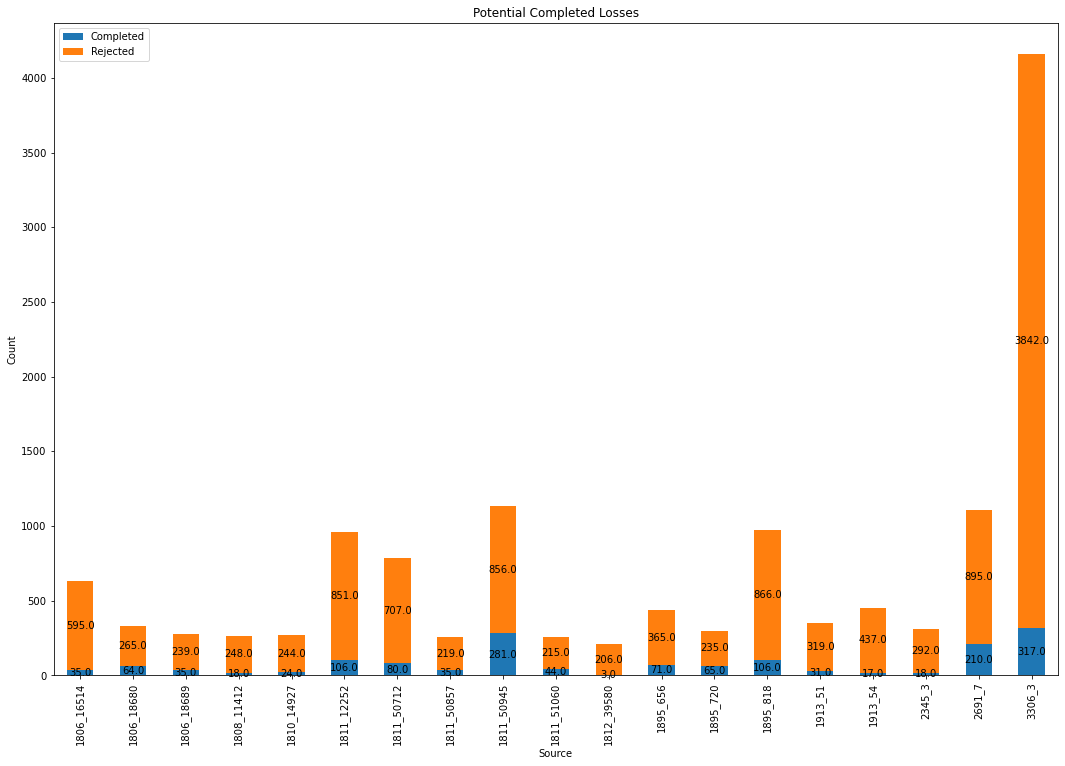

In [23]:
#stacked chart to see how many completed resolutions would be lost if rejected source becomes omitted 

res['Source'] = res['wireId']+'_'+ res['class']
successLoss= res.pivot_table(index=['Source'], columns = ['jflo_resolution'], aggfunc='size')

successLoss=pd.merge(successLoss.reset_index(), majorRej, how='inner').set_index('Source')

successLoss = successLoss.drop(['wireId','class','rejection%','count'], axis=1)

ax = successLoss.plot(kind='bar', stacked = True, figsize = (18,12), rot = 90, xlabel = 'Source', ylabel='Count', title='Potential Completed Losses')
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels = labels, label_type='center')